To begin my EDA for this dataset, I'll start by loading in my libraries, tools, and the dataset itself. From there, I'll load the head, check the shape of the dataframe, and ensure that all the customer entries are unique before proceeding.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import pointbiserialr
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

df = pd.read_excel('Telco_dataset.xlsx')

df.head()

,CustomerID,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,...,Avg Monthly GB Download,Streaming Music,Unlimited Data,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Churn Category,Satisfaction Score,Customer Status,Total Revenue
0,0002-ORFBO,Frazier Park,93225,"34.827662, -118.999073",34.827662,-118.999073,Female,No,Yes,No,...,16,No,Yes,0.00,0,381.51,NaN,3,Stayed,974.81
1,0003-MKNFE,Glendale,91206,"34.162515, -118.203869",34.162515,-118.203869,Male,No,No,No,...,10,Yes,No,38.33,10,96.21,NaN,5,Stayed,610.28
2,0004-TLHLJ,Costa Mesa,92627,"33.645672, -117.922613",33.645672,-117.922613,Male,No,No,No,...,30,No,Yes,0.00,0,134.60,Competitor,1,Churned,415.45
3,0011-IGKFF,Martinez,94553,"38.014457, -122.115432",38.014457,-122.115432,Male,Yes,Yes,No,...,4,No,Yes,0.00,0,361.66,Dissatisfaction,1,Churned,1599.51
4,0013-EXCHZ,Camarillo,93010,"34.227846, -119.079903",34.227846,-119.079903,Female,Yes,Yes,No,...,11,No,Yes,0.00,0,22.14,Dissatisfaction,1,Churned,289.54


In [2]:
print(df.shape) # Checking the shape of the dataframe

(7043, 46)


In [3]:
df['CustomerID'].nunique() # Ensuring each of the entries in the dataset are unique

7043

My EDA plan for this dataset is split between exploring the numerical variables and the categorical variables. Before I start, I am dropping the columns I have determined will not provide any insight or predictive power for this analysis. This includes the customer location data, ID's, and variations of the "Churn" target variable that will not be used. The customer location data (City, Zipcode, Lat/Long) may prove to be useful later, but for now will be dropped.

In [4]:
df = df.drop(columns=["CustomerID", "City", "Zip Code", "Lat Long", "Latitude", "Longitude", "Senior Citizen", "Churn Score", "Churn Reason",
                      "Churn Category", "Customer Status"])

With these variables droppped, I want to make sure there are no null-values in any of the columns, and that the datatypes look correct for each.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 35 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             7043 non-null   object 
 1   Partner                            7043 non-null   object 
 2   Dependents                         7043 non-null   object 
 3   Tenure Months                      7043 non-null   int64  
 4   Phone Service                      7043 non-null   object 
 5   Multiple Lines                     7043 non-null   object 
 6   Internet Service                   7043 non-null   object 
 7   Online Security                    7043 non-null   object 
 8   Online Backup                      7043 non-null   object 
 9   Device Protection                  7043 non-null   object 
 10  Premium Tech Support               7043 non-null   object 
 11  Streaming TV                       7043 non-null   objec

Looking at the results, "Offer" has quite a few null values as 'NaN'. Offer stands for the type of promotional offer that a customer took advantage of when signing up with Telco. Unfortunately, I do not have any domain knowledge over what the Offer's entail. There are five different offers, from "A" through "E". Customers can also sign up without a promotional offer, those values being NaN. Those will be handled when I examine the categorical values. I do not want to drop the Offer column right away despite not knowing what each offer provided for the customers, as the column could prove to be useful.

Total Revenue appears to have 11 null-values. I will fill these in with the median rather than dropping the rows to retain as much information as possible. 

Total Charges appears to be type "Object" which is incorrect. I'll look to change this as well. Other than these issues, the data appears to be sound and ready to be analyzed. I'll start with the numerical variables, looking at their descriptive statistics and distributions. 

In [6]:
df['Age'].describe().round() 

count    7043.0
mean       47.0
std        17.0
min        19.0
25%        32.0
50%        46.0
75%        60.0
max        80.0
Name: Age, dtype: float64

The average age of Telco customers is around 47 years old. The customers' ages range from 19-80, with 50% of the customers falling between 32 and 60.

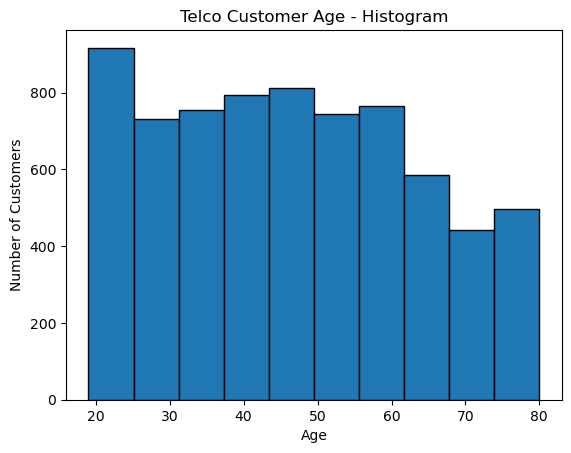

In [7]:
# Age histogram
plt.hist(df['Age'], bins=10, edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Number of Customers')
plt.title('Telco Customer Age - Histogram')
plt.show()

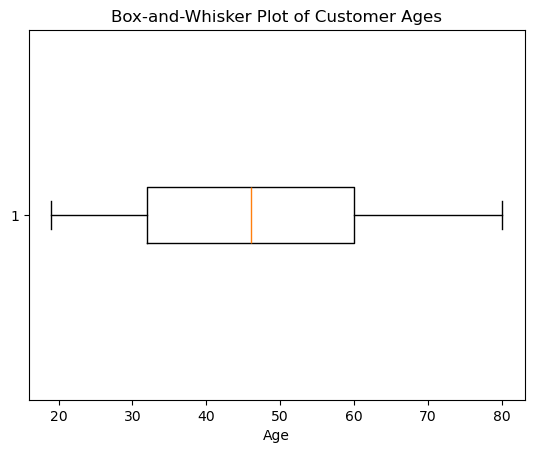

In [8]:
# Age Box-and-Whisker Plot
plt.boxplot(df['Age'], vert=False)
plt.xlabel('Age')
plt.title('Box-and-Whisker Plot of Customer Ages')
plt.show()

Looking at the results of the histogram and box-and-whisker plots, "Age" appears to have a slight positive skew.

In [9]:
df['Tenure Months'].describe().round(2)

count    7043.00
mean       32.37
std        24.56
min         0.00
25%         9.00
50%        29.00
75%        55.00
max        72.00
Name: Tenure Months, dtype: float64

The average Telco customer has been with the company for approximately 32 months. Customer tenure ranges from 0, signifying new customers, and 72, showing that the longest tenured customer(s) has been with the company for six years. 50% of the customers have been with Telco between 9 and 55 months.

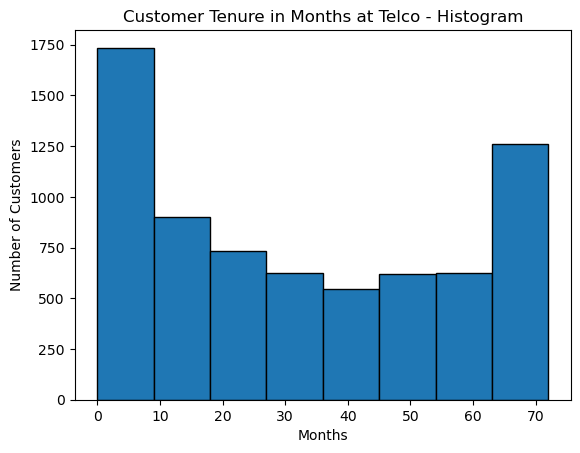

In [10]:
# Tenure Months histogram
plt.hist(df['Tenure Months'], bins=8, edgecolor='black')
plt.xlabel('Months')
plt.ylabel('Number of Customers')
plt.title('Customer Tenure in Months at Telco - Histogram')
plt.show()

The histogram for "Tenure Months" is bimodal, showing two peaks at the beginning and the end. This shows that several of the Telco customers fall into two groups - 1.) Customers that are either new, or have not been with the company for long, and 2. Customers that have been with Telco for a very long time. 

In [11]:
df['Number of Dependents'].value_counts()

Number of Dependents
0    5416
1     553
2     531
3     517
5      10
4       9
6       3
7       2
9       1
8       1
Name: count, dtype: int64

Looking at the number of dependents each customer has, it is clear that the vast majority of Telco customers have no dependents at all. The number of customers with 1, 2, or 3 depenents is fairly equal, significantly dropping off from there for customers that have 4 or more. This suggests to me that the categorical form of this variable, "Dependents", where customers have either no dependents, or have 1+ dependents, would be more useful. I will keep both variables for testing to see how each version performs with different models.

In [12]:
df['Number of Referrals'].value_counts()

Number of Referrals
0     3821
1     1086
5      264
3      255
7      248
9      238
2      236
4      236
10     223
6      221
8      213
11       2
Name: count, dtype: int64

Examining the number of referrals customers have given out, it appears that a little over half have not given out referrals to sign up with Telco (3821/7043 ≈ 54.25%). Of the customers that did, 1086 of them gave out 1 referral, with similar numbers of customers giving out 2-10 of them. There are two outlier customers that referred 11 people to them. 

In [13]:
df['Monthly Charges'].describe().round(2)

count    7043.00
mean       64.76
std        30.09
min        18.25
25%        35.50
50%        70.35
75%        89.85
max       118.75
Name: Monthly Charges, dtype: float64

Looking at these numbers, it appears the average Telco customer pays 64.76/month in Q3. The lowest bill a customer pays per month is 18.25 and the highest they receive is 118.75. 50% of customers pay between 35.50 and 89.85 per month.  

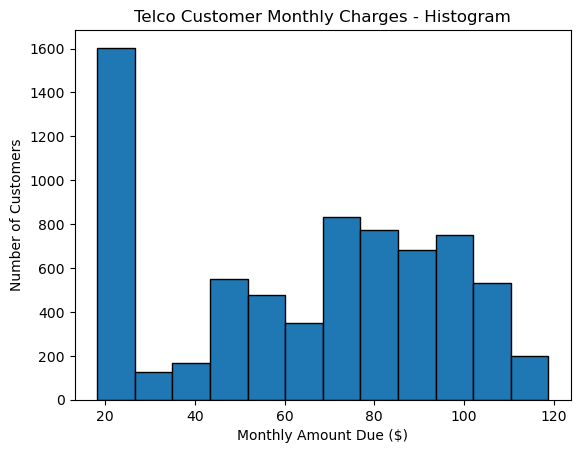

In [14]:
# Monthly Charges histogram
plt.hist(df['Monthly Charges'], bins=12, edgecolor='black')
plt.xlabel('Monthly Amount Due ($)')
plt.ylabel('Number of Customers')
plt.title('Telco Customer Monthly Charges - Histogram')
plt.show()

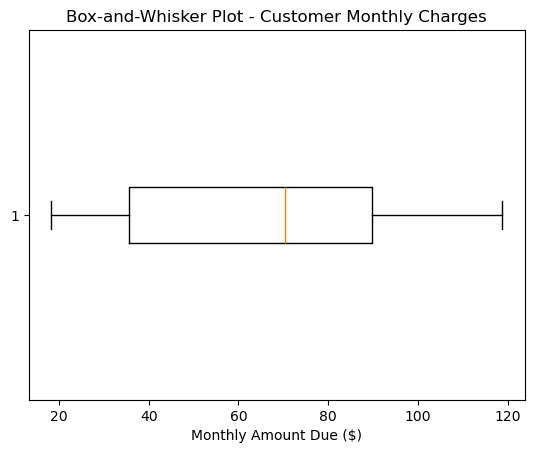

In [15]:
# Monthly Charges Box-and-Whisker Plot
plt.boxplot(df['Monthly Charges'], vert=False)
plt.xlabel('Monthly Amount Due ($)')
plt.title('Box-and-Whisker Plot - Customer Monthly Charges')
plt.show()

Analying the results of both the histogram and box-and-whisker plot, it appears that the distribution is negatively skewed, with more customers paying amounts of $45 or greater per month than those who pay less. A significant group of Telco customers had bills that were around $18-$25. This leads me to believe "Monthly Charges" may do better as a categorical variable, grouping the customers into "low", "moderate", and "high" spenders each month. Like number of dependents, this categorical variable will be kept alongside the original to test which has greater predictive power.

In [16]:
df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce') # Converting to numeric from type "object"

df['Total Charges'] = df['Total Charges'].fillna(df['Total Charges'].mean()) # Replacing the 11 missing values with the mean

df['Total Charges'].describe().round(2)

count    7043.00
mean     2283.30
std      2265.00
min        18.80
25%       402.22
50%      1400.55
75%      3786.60
max      8684.80
Name: Total Charges, dtype: float64

The average Telco has paid 2,283.30 over the course of their tenure. The total charges for customers range from 18.80, signifying a new customer, to 8,684.80. 50% of Telco customers have paid between 402.22 and 3,786.60 during their tenure.

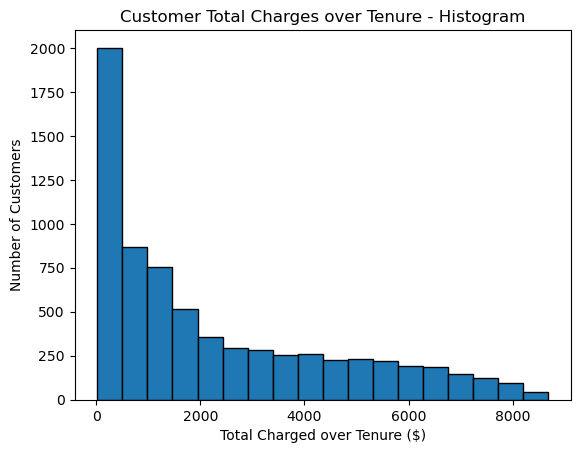

In [17]:
# Total Charges histogram
plt.hist(df['Total Charges'], bins=18, edgecolor='black')
plt.xlabel('Total Charged over Tenure ($)')
plt.ylabel('Number of Customers')
plt.title('Customer Total Charges over Tenure - Histogram')
plt.show()

Looking at the histogram, you can see that the distribution of Total Charges is heavily positively-skewed. This, like Monthly Charges, will be addressed with feature engineering.

In [18]:
# Descriptive statistics for Average Customer Monthly Long Distance Charges
df['Avg Monthly Long Distance Charges'].describe().round(2)

count    7043.00
mean       22.96
std        15.45
min         0.00
25%         9.21
50%        22.89
75%        36.39
max        49.99
Name: Avg Monthly Long Distance Charges, dtype: float64

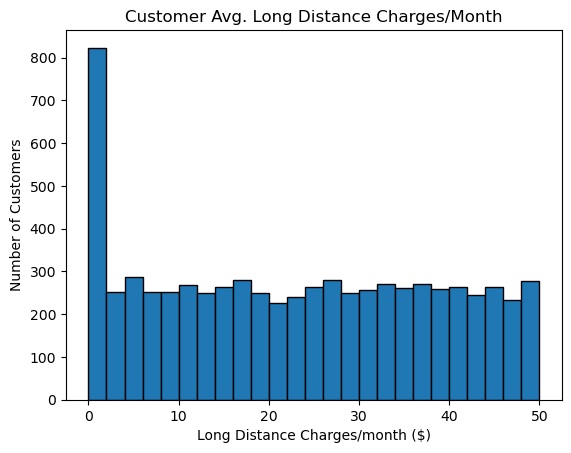

In [19]:
# Average Customer Monthly Long Distance Charges histogram
plt.hist(df['Avg Monthly Long Distance Charges'], bins=25, edgecolor='black')
plt.xlabel('Long Distance Charges/month ($)')
plt.ylabel('Number of Customers')
plt.title('Customer Avg. Long Distance Charges/Month')
plt.show()

In [20]:
# Descriptive statistics for Total Customer Long Distance Charges
df['Total Long Distance Charges'].describe().round(2)

count    7043.00
mean      749.10
std       846.66
min         0.00
25%        70.54
50%       401.44
75%      1191.10
max      3564.72
Name: Total Long Distance Charges, dtype: float64

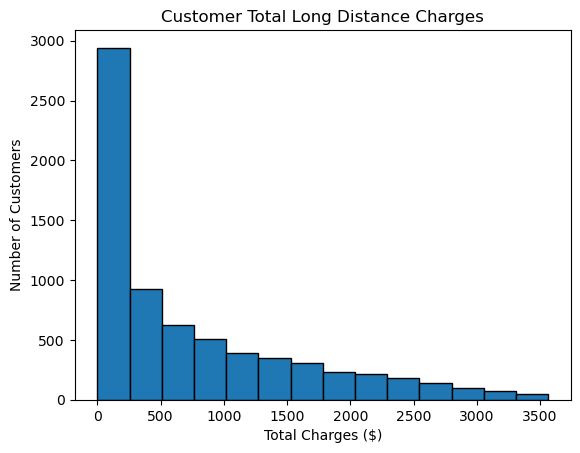

In [21]:
# Average Customer Monthly Long Distance Charges histogram
plt.hist(df['Total Long Distance Charges'], bins=14, edgecolor='black')
plt.xlabel('Total Charges ($)')
plt.ylabel('Number of Customers')
plt.title('Customer Total Long Distance Charges')
plt.show()

In [22]:
# Descriptive statistics for Average Customer GB Download per month
df['Avg Monthly GB Download'].describe().round(2)

count    7043.00
mean       20.52
std        20.42
min         0.00
25%         3.00
50%        17.00
75%        27.00
max        85.00
Name: Avg Monthly GB Download, dtype: float64

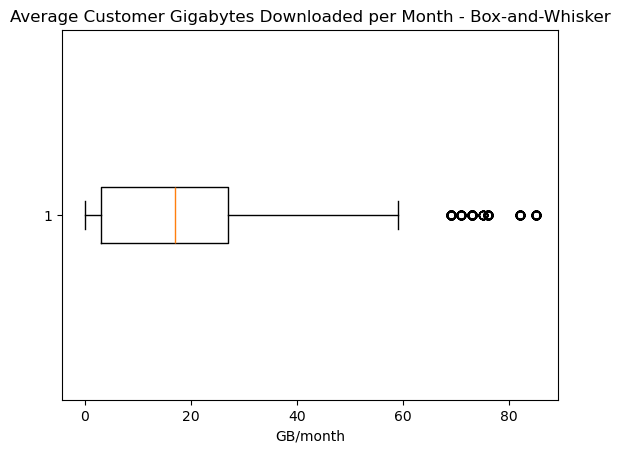

In [23]:
# Average Customer GB Download per month histogram
plt.boxplot(df['Avg Monthly GB Download'], vert=False)
plt.xlabel('GB/month')
plt.title('Average Customer Gigabytes Downloaded per Month - Box-and-Whisker')
plt.show()

Looking at the box-and-whisker plot, it appears that there are several outlier customers, downloading beyond 60GB/month. These are believed to be customers with Unlimited Data plans as part of their contracts. 

In [24]:
# Totaling the number of customers with extra data charges vs customers without
non_zero_total_extra_data_charges = (df['Total Extra Data Charges'] != 0).sum()

zero_total_extra_data_charges = (df['Total Extra Data Charges'] == 0).sum()

print(f"Customers with extra data charges: {non_zero_total_extra_data_charges}, Customers without: {zero_total_extra_data_charges}")

Customers with extra data charges: 728, Customers without: 6315


Since there are a huge majority of customers that do not have any extra data charges, I will only be looking at the descriptive statistics for the customers who do.

In [25]:
total_extra_data_charges_filtered = df[df['Total Extra Data Charges'] > 0]

total_extra_data_charges_filtered['Total Extra Data Charges'].describe().round(2)

count    728.00
mean      66.37
std       46.36
min       10.00
25%       20.00
50%       60.00
75%      100.00
max      150.00
Name: Total Extra Data Charges, dtype: float64

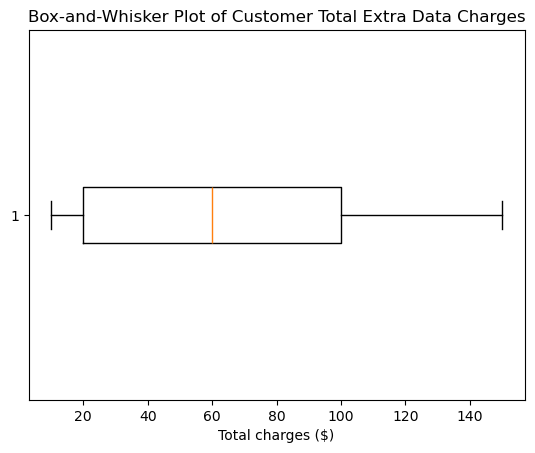

In [26]:
plt.boxplot(total_extra_data_charges_filtered['Total Extra Data Charges'], vert=False)
plt.xlabel('Total charges ($)')
plt.title('Box-and-Whisker Plot of Customer Total Extra Data Charges')
plt.show()

In [27]:
# Totaling the number of customers that received refunds vs customers that did not
non_zero_total_refunds = (df['Total Refunds'] != 0).sum()

zero_total_refunds = (df['Total Refunds'] == 0).sum()

print(f"Customers that received refunds: {non_zero_total_refunds}, Customers that did not: {zero_total_refunds}")

Customers that received refunds: 525, Customers that did not: 6518


Based on this imbalance, I will be transforming this variable into a binary categorical variable to use instead, denoting whether or not a customer has received a refund.

In [28]:
# Customer Lifetime Value descriptive statistics
df['CLTV'].describe().round(2)

count    7043.00
mean     4400.30
std      1183.06
min      2003.00
25%      3469.00
50%      4527.00
75%      5380.50
max      6500.00
Name: CLTV, dtype: float64

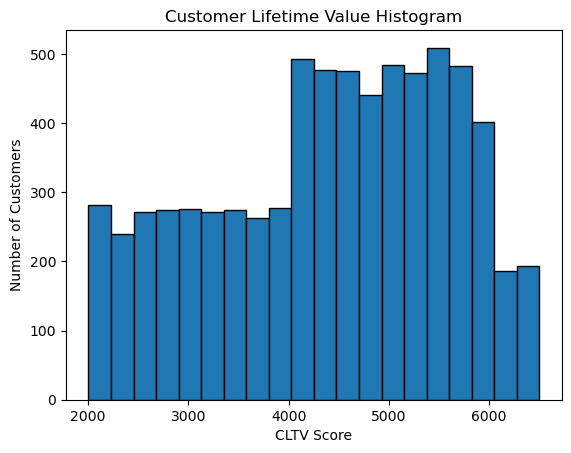

In [29]:
plt.hist(df['CLTV'], bins=20, edgecolor='black')
plt.xlabel('CLTV Score')
plt.ylabel('Number of Customers')
plt.title('Customer Lifetime Value Histogram')
plt.show()

In [30]:
# Average Satisfaction Score of Telco Customers in Q3. 5 being the most satisfied and 1 being the least
df['Satisfaction Score'].mean().round(2)

3.24

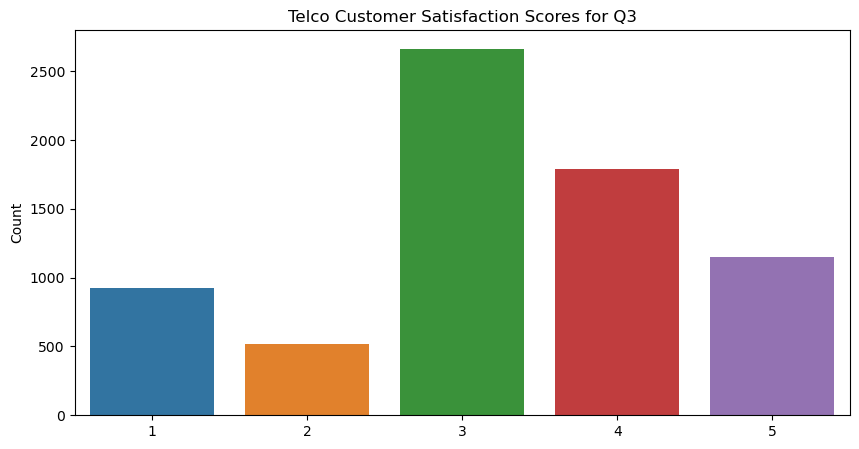

In [31]:
# Distribution of Satisfaction Scores Amongst Customers for Q3
satScore_Counts = df['Satisfaction Score'].value_counts()

plt.figure(figsize=(10,5))

ax = sns.barplot(x=satScore_Counts.index, y=satScore_Counts.values)
    
plt.xlabel('')
plt.ylabel('Count')
plt.title('Telco Customer Satisfaction Scores for Q3')
plt.show()

In [32]:
# Handling the missing 11 values for Total revenue by inputting the average into the NaN's
df['Total Revenue'] = df['Total Revenue'].fillna(df['Total Revenue'].mean())

# Descriptive statistics for customer total revenue
df['Total Revenue'].describe().round(2)

count     7043.00
mean      3038.16
std       2863.59
min         21.36
25%        608.85
50%       2116.94
75%       4801.15
max      11979.34
Name: Total Revenue, dtype: float64

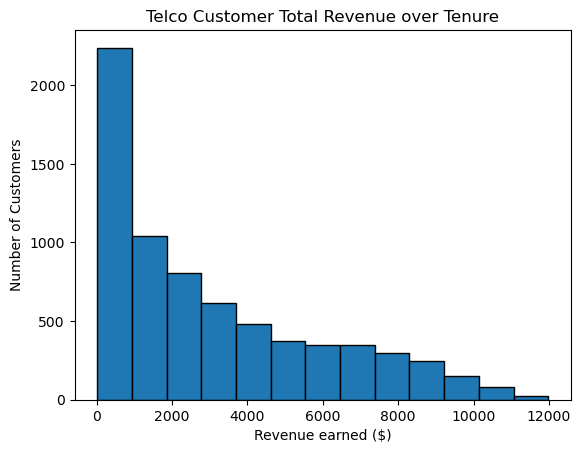

In [33]:
# Customer Total Revenue histogram
plt.hist(df['Total Revenue'], bins=13, edgecolor='black')
plt.xlabel('Revenue earned ($)')
plt.ylabel('Number of Customers')
plt.title('Telco Customer Total Revenue over Tenure')
plt.show()

Now that univariate analysis is complete with the numerical variables, I will measure how they each correlate with our target variable, churn.

In [34]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns # Grouping together all numerical variables

numerical_cols = [col for col in numerical_cols if col not in ["Churn Value"]]

# Providing a summary of the average value for each of the numerical variables that is associated with churning/not churning
churn_summary = df.groupby("Churn Value")[numerical_cols].agg(["mean"])

print(churn_summary)

            Tenure Months Monthly Charges Total Charges         CLTV  \
                     mean            mean          mean         mean   
Churn Value                                                            
0               37.569965       61.265124   2554.765772  4490.921337   
1               17.979133       74.441332   1531.796094  4149.414660   

            Number of Dependents        Age Number of Referrals  \
                            mean       mean                mean   
Churn Value                                                       
0                       0.595284  45.344414            2.468690   
1                       0.118245  49.735688            0.521134   

            Avg Monthly Long Distance Charges Avg Monthly GB Download  \
                                         mean                    mean   
Churn Value                                                             
0                                   22.883572               19.915733   
1          

In [35]:
# Calculating and printing correlation coefficients for numerical variables
correlations = {col: pointbiserialr(df[col], df["Churn Value"])[0] for col in numerical_cols}

correlations_df = pd.DataFrame.from_dict(correlations, orient="index", columns=["Correlation with Churn"])

correlations_df = correlations_df.sort_values(by="Correlation with Churn", ascending=False)

print(correlations_df)

                                   Correlation with Churn
Monthly Charges                                  0.193356
Age                                              0.115760
Avg Monthly GB Download                          0.048868
Avg Monthly Long Distance Charges                0.008120
Total Extra Data Charges                         0.007139
Total Refunds                                   -0.033709
CLTV                                            -0.127463
Total Charges                                   -0.199428
Number of Dependents                            -0.218780
Total Long Distance Charges                     -0.223756
Total Revenue                                   -0.223923
Number of Referrals                             -0.286540
Tenure Months                                   -0.352229
Satisfaction Score                              -0.754649


Analysis for the correlation coefficients:

Satisfaction Score: -0.754649

Satisfaction score has a strong, negative correlation with churn. This makes sense, as a higher satisfaction score should result in a customer staying with Telco, whereas a lower satisfaction score could indicate they are going to churn.


Tenure Months: -0.352229

Tenure has a moderate, negative correlation with churn. This is understandable, as customers that have been with Telco longer are more likely to continue staying with them than customers that have only been with the company a short time.


Number of Referrals: -0.286540

Number of Referrals has a weak, negative correlation with churn. Customers are more likely to give out referrals when they are happy with their service than when they are not. A higher number of referrals given out should signify a lower likelihood to churn.


Total Revenue: -0.223923

Total Revenue has a weak, negative correlation with churn.


Total Long Distance Charges: -0.223756

Total Long Distance Charges has a weak, negative correlation with churn.


Number of Dependents: -0.218780

Number of Dependents has a weak, negative correlation with churn.


Total Charges: -0.199428

Total Charges has a weak, negative correlation with churn.


Monthly Charges: 0.193356

Monthly Charges has a weak, positive correlation with churn.


CLTV: -0.127463

Customer Lifetime Value (CLTV) has a weak, negative correlation with churn.


Age: 0.115760

Age has a weak, positive correlation with churn.


Avg Monthly GB Download: 0.048868

Average Monthly GB Download has a weak, positive correlation with churn.


Total Refunds: -0.033709

Total Refunds has a weak, negative correlation with churn.


Avg Monthly Long Distance Charges: .008120

Average Monthly Long Distance Charges has a weak, positive correlation with churn.


Total Extra Data Charges: .007139

Total Extra Data Charges has a weak, positive correlation with churn.




Before I make a decision on which of these variables to drop moving into model testing, I want to transform these numerical variables to determine if I can add any additional predictive power to them, or make them into a more useful form. I will be measuring correlations using the variables log, using a MinMax scaler, and using a standard scaler. I will compare these correlation coefficients to the originals to make my decision.

In [36]:
# Log-transformation of numerical variables
numerical_cols.append("Churn Value")

log_transformed = df[numerical_cols].copy()

for col in numerical_cols:
    if (df[col] > 0).all():  
        log_transformed[col] = np.log1p(df[col])

log_correlations = log_transformed.corr()["Churn Value"].sort_values(ascending=False)

print("Log-transformed correlations with Churn:\n", log_correlations)

Log-transformed correlations with Churn:
 Churn Value                          1.000000
Monthly Charges                      0.210109
Age                                  0.103618
Avg Monthly GB Download              0.048868
Avg Monthly Long Distance Charges    0.008120
Total Extra Data Charges             0.007139
Total Refunds                       -0.033709
CLTV                                -0.125392
Number of Dependents                -0.218780
Total Long Distance Charges         -0.223756
Total Charges                       -0.242270
Total Revenue                       -0.279566
Number of Referrals                 -0.286540
Tenure Months                       -0.352229
Satisfaction Score                  -0.789949
Name: Churn Value, dtype: float64


In [37]:
# Transforming variables using MinMax scaler
normalized_df = df[numerical_cols].copy()
scaler = MinMaxScaler()
normalized_df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
normalized_correlations = normalized_df.corr()["Churn Value"].sort_values(ascending=False)
print("MinMax correlations with Churn:\n", normalized_correlations)

MinMax correlations with Churn:
 Churn Value                          1.000000
Monthly Charges                      0.193356
Age                                  0.115760
Avg Monthly GB Download              0.048868
Avg Monthly Long Distance Charges    0.008120
Total Extra Data Charges             0.007139
Total Refunds                       -0.033709
CLTV                                -0.127463
Total Charges                       -0.199428
Number of Dependents                -0.218780
Total Long Distance Charges         -0.223756
Total Revenue                       -0.223923
Number of Referrals                 -0.286540
Tenure Months                       -0.352229
Satisfaction Score                  -0.754649
Name: Churn Value, dtype: float64


In [38]:
# Transforming variables using Standard scaler
standardized_df = df[numerical_cols].copy()
scaler = StandardScaler()
standardized_df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
standardized_correlations = standardized_df.corr()["Churn Value"].sort_values(ascending=False)
print("Standardized correlations with Churn:\n", standardized_correlations)

Standardized correlations with Churn:
 Churn Value                          1.000000
Monthly Charges                      0.193356
Age                                  0.115760
Avg Monthly GB Download              0.048868
Avg Monthly Long Distance Charges    0.008120
Total Extra Data Charges             0.007139
Total Refunds                       -0.033709
CLTV                                -0.127463
Total Charges                       -0.199428
Number of Dependents                -0.218780
Total Long Distance Charges         -0.223756
Total Revenue                       -0.223923
Number of Referrals                 -0.286540
Tenure Months                       -0.352229
Satisfaction Score                  -0.754649
Name: Churn Value, dtype: float64


Based on the results of the correlation testing, I have decided to use the following numerical variables in my model building/feature selection:


1 - Log-transformed Satisfaction Score

2 - Tenure Months

3 - Number of Referrals

4 - Total Long Distance Charges

5 - Log-transformed Total Revenue

6 - Log-transformed Total Charges

7 - Log-transformed Monthly Charges

8 - Number of Dependents (To be tested with XGBoost and Random Forest. I will be using the Dependents categorical for Logistic Regression.)

9 - CLTV


The rest of the numerical variables will be dropped.

Now that my decison has been made regarding the numerical variables, I will now analyze the categorical variables of the dataset.

In [39]:
df['Gender'].value_counts()

Gender
Male      3555
Female    3488
Name: count, dtype: int64

In [40]:
df['Partner'].value_counts()

Partner
No     3641
Yes    3402
Name: count, dtype: int64

In [41]:
# How many customers have dependents?
df['Dependents'].value_counts()

Dependents
No     5416
Yes    1627
Name: count, dtype: int64

In [42]:
# How many customers have referred a friend to Telco?
df['Referred a Friend'].value_counts()

Referred a Friend
No     3821
Yes    3222
Name: count, dtype: int64

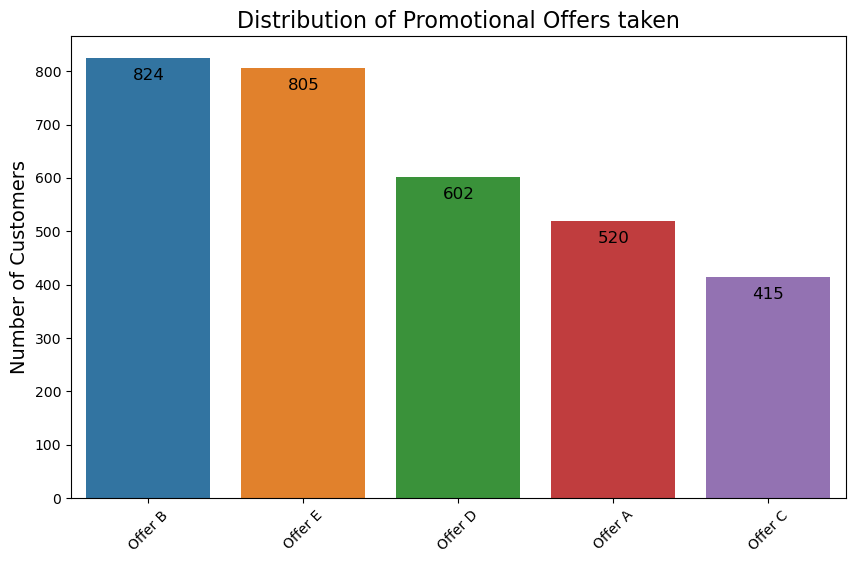

In [43]:
# Bar graph with labels for the distribution of offers 

offer_counts = df['Offer'].value_counts()

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=offer_counts.index, y=offer_counts.values)

for i, value in enumerate(offer_counts.values):
    ax.text(i, value - (0.05 * max(offer_counts.values)), str(value), ha='center', fontsize=12, color='black')

plt.xlabel(" ")
plt.ylabel("Number of Customers", fontsize=14)
plt.title("Distribution of Promotional Offers taken", fontsize=16)
plt.xticks(rotation=45)

plt.show()

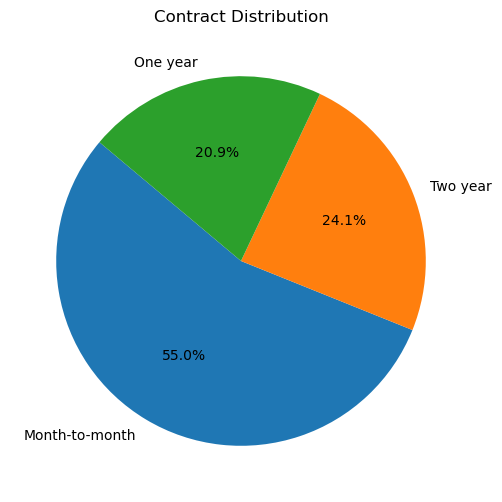

In [44]:
# Determining how many customers are on one-year, two-year, and month-to-month contracts
contract_counts = df['Contract'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(contract_counts, labels=contract_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Contract Distribution')
plt.show()

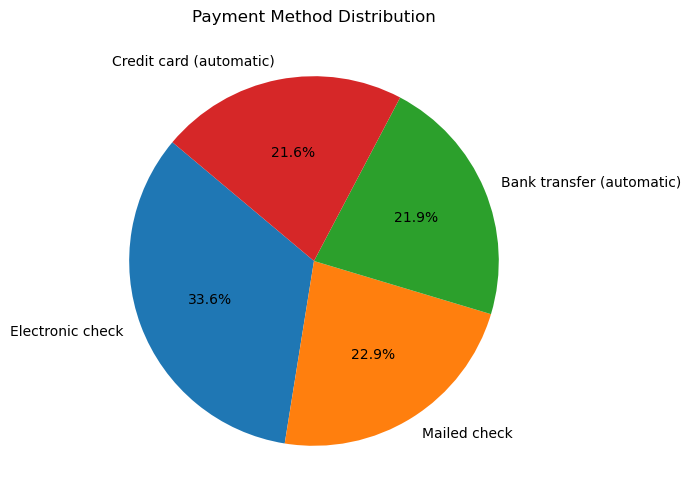

In [45]:
# Determining the breakdown of what payment methods customers use
payment_method_counts = df['Payment Method'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(payment_method_counts, labels=payment_method_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Payment Method Distribution')
plt.show()

In [46]:
# What percentage of customers have phone service?
df['Phone Service'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%'

Phone Service
Yes    90.32%
No      9.68%
Name: proportion, dtype: object

In [47]:
# Do customers have multiple phone lines on their contract?
df['Multiple Lines'].value_counts()

Multiple Lines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64

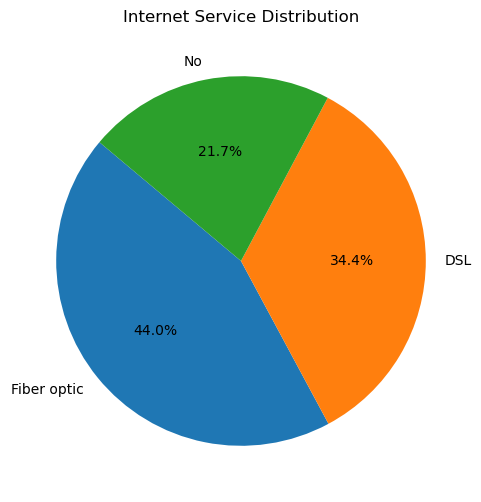

In [48]:
# Determining the breakdown of what type of internet service the customers have (if at all)
iService_counts = df['Internet Service'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(iService_counts, labels=iService_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Internet Service Distribution')
plt.show()

In [49]:
df['Online Backup'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%'

Online Backup
No                     43.84%
Yes                    34.49%
No internet service    21.67%
Name: proportion, dtype: object

In [50]:
df['Online Security'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%'

Online Security
No                     49.67%
Yes                    28.67%
No internet service    21.67%
Name: proportion, dtype: object

In [51]:
df['Device Protection'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%'

Device Protection
No                     43.94%
Yes                    34.39%
No internet service    21.67%
Name: proportion, dtype: object

In [52]:
df['Premium Tech Support'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%'

Premium Tech Support
No                     49.31%
Yes                    29.02%
No internet service    21.67%
Name: proportion, dtype: object

In [53]:
df['Streaming TV'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%'

Streaming TV
No                      39.9%
Yes                    38.44%
No internet service    21.67%
Name: proportion, dtype: object

In [54]:
df['Streaming Movies'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%'

Streaming Movies
No                     39.54%
Yes                    38.79%
No internet service    21.67%
Name: proportion, dtype: object

In [55]:
# Checking what percentage of customers Streams Music
df['Streaming Music'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%'

Streaming Music
No     64.67%
Yes    35.33%
Name: proportion, dtype: object

In [56]:
# Determining what percentage of customers has Unlimited Data in their contract
df['Unlimited Data'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%'

Unlimited Data
Yes    67.37%
No     32.63%
Name: proportion, dtype: object

In [57]:
# Checking what percentage of customers use paperless billing
df['Paperless Billing'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%'

Paperless Billing
Yes    59.22%
No     40.78%
Name: proportion, dtype: object

Now that I've looked over the categorical variables, I will begin to explore their association with churn. I'll do this by first using a chi-square test to check for significant relationships between the variables and churn.

In [58]:
# Chi-square test
categorical_features = ['Unlimited Data', 'Streaming Music', 'Streaming Movies', 'Streaming TV', 'Offer', 'Referred a Friend', 'Payment Method', 
                        'Paperless Billing', 'Contract', 'Premium Tech Support', 'Device Protection', 'Online Backup', 'Online Security',
                        'Internet Service', 'Multiple Lines', 'Dependents', 'Partner']

chi_square_results = []

for col in categorical_features:
    contingency_table = pd.crosstab(df[col], df["Churn Value"])
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

    chi_square_results.append({
        "Feature": col,
        "Chi2 Statistic": chi2,
        "p-value": p
    })

chi_square_df = pd.DataFrame(chi_square_results).sort_values(by="p-value")
print(chi_square_df)

                 Feature  Chi2 Statistic        p-value
8               Contract     1184.596572  5.863038e-258
12       Online Security      849.998968  2.661150e-185
9   Premium Tech Support      828.197068  1.443084e-180
13      Internet Service      732.309590  9.571788e-160
6         Payment Method      648.142327  3.682355e-140
11         Online Backup      601.812790  2.079759e-131
10     Device Protection      558.419369  5.505219e-122
4                  Offer      488.635809  1.922257e-104
15            Dependents      433.734379   2.500972e-96
2       Streaming Movies      375.661479   2.667757e-82
3           Streaming TV      374.203943   5.528994e-82
7      Paperless Billing      258.277649   4.073355e-58
0         Unlimited Data      194.549217   3.231434e-44
16               Partner      158.733382   2.139911e-36
5      Referred a Friend      155.940342   8.723768e-36
1        Streaming Music       14.421460   1.461276e-04
14        Multiple Lines       11.330441   3.464

Next, I will utilize a Cramer's V test to check the strength of the relationships in the chi-square test between the categorical variables and churn. Values of 0.0 - 0.1 consider the correlation to be weak, values of 0.1 - 0.3 are considered moderate, values of 0.3 - 0.5 are considered strong, and values greater than 0.5 are considered very strong.

In [59]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(df[x], df[y])
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

for feature in categorical_features:
    v = cramers_v(feature, 'Churn Value')
    print(f"Cramer's V for {feature} vs Churn: {v:.4f}")

Cramer's V for Unlimited Data vs Churn: 0.1662
Cramer's V for Streaming Music vs Churn: 0.0453
Cramer's V for Streaming Movies vs Churn: 0.2310
Cramer's V for Streaming TV vs Churn: 0.2305
Cramer's V for Offer vs Churn: 0.3929
Cramer's V for Referred a Friend vs Churn: 0.1488
Cramer's V for Payment Method vs Churn: 0.3034
Cramer's V for Paperless Billing vs Churn: 0.1915
Cramer's V for Contract vs Churn: 0.4101
Cramer's V for Premium Tech Support vs Churn: 0.3429
Cramer's V for Device Protection vs Churn: 0.2816
Cramer's V for Online Backup vs Churn: 0.2923
Cramer's V for Online Security vs Churn: 0.3474
Cramer's V for Internet Service vs Churn: 0.3225
Cramer's V for Multiple Lines vs Churn: 0.0401
Cramer's V for Dependents vs Churn: 0.2482
Cramer's V for Partner vs Churn: 0.1501


Based on the results of the chi-square and the cramer's v, I've decided to move forward with Online Security, Device Protection, Unlimited Data, Streaming TV, Streaming Movies, Paperless Billing, Referred a Friend, and Partner. I will map these categorical variables to numerical values. Once that's done, I will create interaction terms with the remaining variables in order to get better predictive results combined than with the two variables individually. The interaction terms I've chosen were selected through a series of many mi-score tests that I've chosen not to include in this notebook. The interaction terms were picked out based on high mi-scores. Mi-scores, or mutual-information scores, measure dependency between two variables, telling you how much knowing one variable reduces uncertaintly about the other, helping to decide whether an interaction will provide additional predictive power. Once those are created, I will add them together into a dataframe for futher testing and analysis.

In [60]:
df["Online Security"] = df["Online Security"].map({"Yes": 1, "No": 0, "No internet service": 2})
df["Device Protection"] = df["Device Protection"].map({"Yes": 1, "No": 0, "No internet service": 2})
df["Unlimited Data"] = df["Unlimited Data"].map({"Yes": 1, "No": 0, "No internet service": 2})
df["Streaming TV"] = df["Streaming TV"].map({"Yes": 1, "No": 0, "No internet service": 2})
df["Streaming Movies"] = df["Streaming Movies"].map({"Yes": 1, "No": 0, "No internet service": 2})
df["Paperless Billing"] = df["Paperless Billing"].map({"Yes": 1, "No": 0})
df["Referred a Friend"] = df["Referred a Friend"].map({"Yes": 1, "No": 0})
df["Partner"] = df["Partner"].map({"Yes": 1, "No": 0})
df["Churn"] = df["Churn Label"].map({"Yes": 1, "No": 0})

interaction_terms = {
    "PaperlessBilling_OnlineSecurity": (df["Paperless Billing"] == 1) & (df["Online Security"] == 0),
    "DeviceProtection_OnlineSecurity": (df["Device Protection"] == 0) & (df["Online Security"] == 0),
    "UnlimitedData_OnlineSecurity": (df["Unlimited Data"] == 0) & (df["Online Security"] == 0),
    "ReferredFriend_OnlineSecurity": (df["Referred a Friend"] == 0) & (df["Online Security"] == 0),
    "PaperlessBilling_DeviceProtection": (df["Paperless Billing"] == 1) & (df["Device Protection"] == 0),
    "Partner_DeviceProtection": (df["Partner"] == 0) & (df["Device Protection"] == 0),
    "ReferredFriend_DeviceProtection": (df["Referred a Friend"] == 0) & (df["Device Protection"] == 0),
    "UnlimitedData_DeviceProtection": (df["Unlimited Data"] == 1) & (df["Device Protection"] == 0),
    "StreamingTV_OnlineSecurity": (df["Streaming TV"] == 0) & (df["Online Security"] == 0),
    "PaperlessBilling_ReferredFriend": (df["Paperless Billing"] == 1) & (df["Referred a Friend"] == 0),
    "StreamingMovies_OnlineSecurity": (df["Streaming Movies"] == 0) & (df["Online Security"] == 0),
    "PaperlessBilling_Partner": (df["Paperless Billing"] == 1) & (df["Partner"] == 0),
    "ReferredFriend_UnlimitedData": (df["Referred a Friend"] == 0) & (df["Unlimited Data"] == 1),
    "Partner_UnlimitedData": (df["Partner"] == 0) & (df["Unlimited Data"] == 1),
    "PaperlessBilling_UnlimitedData": (df["Paperless Billing"] == 1) & (df["Unlimited Data"] == 1),
}

interaction_df = pd.DataFrame({k: v.astype(int) for k, v in interaction_terms.items()})

df_reset = df.reset_index(drop=True)
interaction_df_reset = interaction_df.reset_index(drop=True)

df = pd.concat([df_reset, interaction_df_reset], axis=1)

interaction_df["Churn"] = df["Churn"]
X_interactions = interaction_df.drop(columns=["Churn"])  
y_interactions = interaction_df["Churn"]  
X_interactions = X_interactions.astype(int)

# Calculate MI scores for interaction terms
mi_scores = mutual_info_classif(X_interactions, y_interactions, discrete_features=True)
mi_df = pd.DataFrame({"Feature": X_interactions.columns, "MI Score": mi_scores})
mi_df = mi_df.sort_values(by="MI Score", ascending=False)
print(mi_df)

                              Feature  MI Score
0     PaperlessBilling_OnlineSecurity  0.051047
1     DeviceProtection_OnlineSecurity  0.046340
3       ReferredFriend_OnlineSecurity  0.042963
4   PaperlessBilling_DeviceProtection  0.031105
5            Partner_DeviceProtection  0.029125
6     ReferredFriend_DeviceProtection  0.029091
7      UnlimitedData_DeviceProtection  0.024689
8          StreamingTV_OnlineSecurity  0.024240
9     PaperlessBilling_ReferredFriend  0.023496
10     StreamingMovies_OnlineSecurity  0.023025
11           PaperlessBilling_Partner  0.022866
12       ReferredFriend_UnlimitedData  0.021702
13              Partner_UnlimitedData  0.021126
14     PaperlessBilling_UnlimitedData  0.020685
2        UnlimitedData_OnlineSecurity  0.004295


Finally, I will look to test these new interaction terms for feature importance in both a Random Forest Classifier and a Logistic Regression Model in order to help determine which to move forward with into model building/feature selection.

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X_interactions, y_interactions, test_size=0.2, random_state=42)

# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importances
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    "Feature": X_interactions.columns,
    "Importance": importances
})

feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)
print(feature_importance_df)

                              Feature  Importance
0     PaperlessBilling_OnlineSecurity    0.197381
1     DeviceProtection_OnlineSecurity    0.155627
3       ReferredFriend_OnlineSecurity    0.135641
8          StreamingTV_OnlineSecurity    0.079727
10     StreamingMovies_OnlineSecurity    0.075100
4   PaperlessBilling_DeviceProtection    0.065007
6     ReferredFriend_DeviceProtection    0.059382
5            Partner_DeviceProtection    0.048860
9     PaperlessBilling_ReferredFriend    0.035990
14     PaperlessBilling_UnlimitedData    0.028428
12       ReferredFriend_UnlimitedData    0.027360
11           PaperlessBilling_Partner    0.027015
13              Partner_UnlimitedData    0.021958
7      UnlimitedData_DeviceProtection    0.021698
2        UnlimitedData_OnlineSecurity    0.020828


In [62]:
X_train, X_test, y_train, y_test = train_test_split(X_interactions, y_interactions, test_size=0.2, random_state=42)

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Get coefficients
coef_df = pd.DataFrame({
    "Feature": X_interactions.columns,
    "Coefficient": log_reg.coef_[0]
})

coef_df['abs_coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='abs_coefficient', ascending=False)
print(coef_df)

                              Feature  Coefficient  abs_coefficient
2        UnlimitedData_OnlineSecurity     0.845857         0.845857
0     PaperlessBilling_OnlineSecurity     0.804190         0.804190
12       ReferredFriend_UnlimitedData     0.651831         0.651831
5            Partner_DeviceProtection     0.594657         0.594657
6     ReferredFriend_DeviceProtection    -0.496608         0.496608
7      UnlimitedData_DeviceProtection     0.473882         0.473882
1     DeviceProtection_OnlineSecurity     0.358576         0.358576
14     PaperlessBilling_UnlimitedData     0.275212         0.275212
13              Partner_UnlimitedData    -0.265989         0.265989
3       ReferredFriend_OnlineSecurity     0.244012         0.244012
4   PaperlessBilling_DeviceProtection    -0.204489         0.204489
10     StreamingMovies_OnlineSecurity     0.070892         0.070892
8          StreamingTV_OnlineSecurity     0.061687         0.061687
11           PaperlessBilling_Partner     0.0107

Based on the results of the chi-square, strength of association testing (Cramer's V), mutual-information scores, and feature importance testing, I have decided to use the following categorical variables in my model building/feature selection:


1 - Offer

2 - Payment Method

3 - Contract

4 - Premium Tech Support

5 - Online Security

6 - Internet Service

7 - Dependents

8 - Unlimited Data

9 - Streaming Movies

10 - Streaming TV

11 - Referred a Friend

12 - Paperless Billing

13 - Device Protection

14 - Online Backup

15 - Partner

And these interaction terms:


16 - PaperlessBilling_OnlineSecurity (yes-no)

17 - DeviceProtection_OnlineSecurity (no-no)

18 - ReferredFriend_OnlineSecurity (no-no)

19 - Partner_DeviceProtection (no-no)

20 - ReferredFriend_DeviceProtection (no-no)

21 - UnlimitedData_DeviceProtection (yes-no)

22 - ReferredFriend_UnlimitedData (no-yes)

23 - UnlimitedData_OnlineSecurity (no-no)


In addition, the "Total Refunds" numerical variable will be transformed into a binary categorical variable: ReceivedRefund, which will be tested as welled.